#### Task 1.1: Data Understanding

Explore the incidents dataset using analytical tools and write a concise "data understanding" report that assesses data quality, the distribution of variables, and pairwise correlations.

#### Task 1.2: Data Preparation

Improve the quality of your data and prepare it by extracting new features interesting for describing the incidents. Some examples of indicators to be computed are:

- How many males are involved in incidents relative to the total number of males for the same city and in the same period?
- How many injured and killed people have been involved relative to the total injured and killed people in the same congressional district in a given period of time?
- Ratio of the number of killed people in the incidents relative to the number of participants in the incident
- Ratio of unharmed people in the incidents relative to the average of unharmed people in the same period

Note that these examples are not mandatory, and teams can define their own indicators. Each indicator must be correlated with a description and, when necessary, its mathematical formulation. The extracted variables will be useful for the clustering analysis in the second project's task. Once the set of indicators is computed, the team should explore the new features for a statistical analysis, including distributions, outliers, visualizations, and correlations.

Subtasks of Data Understanding:

- Data semantics for each feature not described above and the new ones defined by the team
- Distribution of the variables and statistics
- Assessing data quality (missing values, outliers, duplicated records, errors)
- Variables transformations
- Pairwise correlations and eventual elimination of redundant variables

Nice visualization and insights can be obtained by exploiting the latitude and longitude features ([example](https://plotly.com/python/getting-started/)).

# Task 1.1:

We have to do some data understanding, so we're gonna explore the dataset. We can start with a simple analysis that establish the variable inside our dataset and visualize a bunch of their distibution, type, etc...

In [2]:
# This will take a while
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import plotly.offline as py


# Set a seed for reproducibility
np.random.seed(42)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Dataset Structure

Let's breakdown the dataset :

- 28 Columns features: Some categorical like date, state etc... Others numerics: n_participants, n_males...
- At the end we've got some notes we could drop, these are not data we can easily manage with statistical tools

In [3]:
# Import the dataset

# Gun incidents data
df_incidents = pd.read_csv('../source/ds/incidents.csv')

# Poverty by state and year
df_poverty = pd.read_csv('../source/ds/povertyByStateYear.csv')

# Year-state-district-house
df_ysdh = pd.read_csv('../source/ds/year_state_district_house.csv')
# Visualize data table

#df_incidents.columns
#df_incidents.dtypes

df_incidents.head()
#df_poverty.head()


/tmp/ipykernel_37220/1905877674.py:4: DtypeWarning:

Columns (15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.



,date,state,city_or_county,address,latitude,longitude,congressional_district,state_house_district,state_senate_district,participant_age1,...,n_males,n_females,n_killed,n_injured,n_arrested,n_unharmed,n_participants,notes,incident_characteristics1,incident_characteristics2
0,2015-05-02,Indiana,Indianapolis,Lafayette Road and Pike Plaza,39.8322,-86.2492,7.0,94.0,33.0,19.0,...,1.0,0.0,0,1,0.0,0.0,1.0,Teen wounded while walking - Security guard at...,Shot - Wounded/Injured,NaN
1,2017-04-03,Pennsylvania,Kane,5647 US 6,41.6645,-78.7856,5.0,NaN,NaN,62.0,...,1.0,0.0,1,0,0.0,0.0,1.0,shot self after accident,"Shot - Dead (murder, accidental, suicide)",Suicide^
2,2016-11-05,Michigan,Detroit,6200 Block of East McNichols Road,42.4190,-83.0393,14.0,4.0,2.0,NaN,...,NaN,NaN,0,1,0.0,1.0,2.0,1 inj.,Shot - Wounded/Injured,NaN
3,2016-10-15,District of Columbia,Washington,"1000 block of Bladensburg Road, NE",38.9030,-76.9820,1.0,NaN,NaN,NaN,...,1.0,0.0,0,1,0.0,0.0,2.0,NaN,Shot - Wounded/Injured,NaN
4,2030-06-14,Pennsylvania,Pittsburgh,California and Marshall Avenues,40.4621,-80.0308,14.0,NaN,NaN,NaN,...,1.0,0.0,0,1,0.0,1.0,2.0,NaN,Shot - Wounded/Injured,"Drive-by (car to street, car to car)"


In [4]:
# show notes only where is present string 'gun'
df_incidents['notes'].str.contains('gun', case=False).head()

#Show those that have true

0    False
1    False
2    False
3      NaN
4      NaN
Name: notes, dtype: object

In [5]:
print("--"*50)
df_poverty.info()
print("--"*50)
df_ysdh.info()
print("--"*50)
df_incidents.info()

----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884 entries, 0 to 883
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   state              884 non-null    object 
 1   year               884 non-null    int64  
 2   povertyPercentage  832 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 20.8+ KB
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10441 entries, 0 to 10440
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   year                    10441 non-null  int64 
 1   state                   10441 non-null  object
 2   congressional_district  10441 non-null  int64 
 3   party             

## Dataset with all feature cross data 

We can join the three dataset for a better understanding, maybe could not be useful if the features are too many.

In [6]:
# Join datasets per state?

In [7]:

# Example of unusable data

df_incidents['notes'].sample(10)
df_incidents['incident_characteristics1'].sample(10)


74813                                Shot - Wounded/Injured
103395            Shot - Dead (murder, accidental, suicide)
77081                                 Non-Shooting Incident
238119                               Shot - Wounded/Injured
195484    Armed robbery with injury/death and/or evidenc...
3449                                 Shot - Wounded/Injured
206633                                Non-Shooting Incident
208849            Shot - Dead (murder, accidental, suicide)
125664            Shot - Dead (murder, accidental, suicide)
171125                               Shot - Wounded/Injured
Name: incident_characteristics1, dtype: object

# Data Cleaning
  
- [ ] Check for errors in datasets and correct if possible
- [x] Remove NaNs
- [x] Remove Duplicates
- [x] Remove columns with a lot of NaNs [Note this has to be done before removing NaNs]
- [x] Outliers
- [x] Remove Unnecessary data for statistical analysis
    

In [8]:
# Exploring dataset errors, there are various type such as: cities located in wrong states, 
# wrong years in incident dataframe (incidents in 2029 and 2030, maybe they were 2019-2020 since data is until 2020)

# Changing dates in df_incidents

df_incidents['date'] = df_incidents['date'].str.replace('2028', '2018')
df_incidents['date'] = df_incidents['date'].str.replace('2029', '2019')
df_incidents['date'] = df_incidents['date'].str.replace('2030', '2020')

df_incidents['date'].str.split('-').str[0].unique()

array(['2015', '2017', '2016', '2020', '2014', '2018', '2019', '2013'],
      dtype=object)

In [9]:
# Remove NaNs

# How do we define if a columns has a lot of nans?
df_incidents.isna().sum()

#   Let's get the % of nans with respect to the total number of records, if is > 50% we drop the column

for col in df_incidents.columns:
    pct_missing = np.mean(df_incidents[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

    # drop if more than 50% of the data is missing
    if pct_missing > 0.5:
        df_incidents.drop(col, axis=1, inplace=True)


#df_incidents.shape

# Finally deleting all NaNs
df_incidents_nona = df_incidents.dropna()

date - 0%
state - 0%
city_or_county - 0%
address - 7%
latitude - 3%
longitude - 3%
congressional_district - 5%
state_house_district - 16%
state_senate_district - 13%
participant_age1 - 39%
participant_age_group1 - 18%
participant_gender1 - 15%
min_age_participants - 31%
avg_age_participants - 31%
max_age_participants - 31%
n_participants_child - 18%
n_participants_teen - 18%
n_participants_adult - 18%
n_males - 15%
n_females - 15%
n_killed - 0%
n_injured - 0%
n_arrested - 12%
n_unharmed - 12%
n_participants - 0%
notes - 34%
incident_characteristics1 - 0%
incident_characteristics2 - 41%


In [10]:
# Remove Duplicates

df_incidents_nodup = df_incidents_nona.drop_duplicates()


## Mass Shooting

As we can see sometimes the number of people killed or injured it's not an incident it's a mass shooting

Let's remove this by taking into account this definition

```
    FBI Definition: The Federal Bureau of Investigation (FBI) defines a mass shooting as an incident in which four or more people, not including the shooter, are killed. This definition is often used in the United States.
```

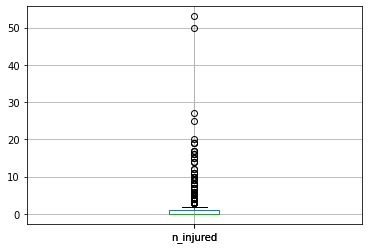

In [11]:
# Let's visualize outliers with a boxplot

df_incidents_nodup.boxplot(column='n_killed')
df_incidents_nodup.boxplot(column='n_injured')

# Remove outliers if n_killed or n_injured > 4
df_incident_no_outliers = df_incidents_nodup[(df_incidents_nodup['n_killed'] < 4) & (df_incidents_nodup['n_injured'] < 4)]

<AxesSubplot:>

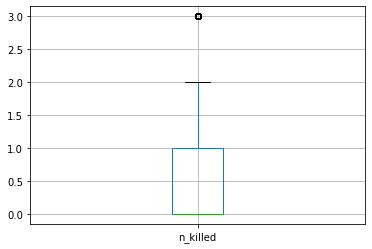

In [12]:
df_incident_no_outliers.boxplot(column='n_killed')

## Visualize Distributions

From the first we can see that plotting distirbution of n_killed against the number of incidents we can see that in the majority of the incidents people do not die. 

We have a distribution skewed to the left so the asimmetry index must be positive.

### Distribution of Killed People

n_killed
0    69.318337
1    26.495226
2     3.614317
3     0.572120
dtype: float64


 Skewness of n_killed: 1.582712


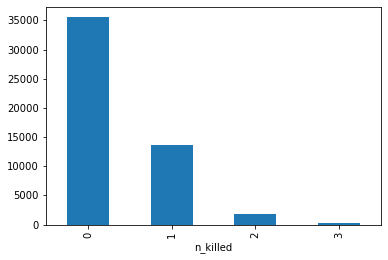

In [13]:
# Using seaborn to visualize the distribution of n_killed 

# In %
print((df_incident_no_outliers.groupby('n_killed').size()/len(df_incident_no_outliers)*100))

df_incident_no_outliers['n_killed'].value_counts().plot(kind='bar')

# PIE CHARTs ARE ILLEGAL
#df_incident_no_outliers['n_killed'].value_counts().plot(kind='pie')

# Asimmetry index is pos
skewness_n_killed = df_incident_no_outliers['n_killed'].skew()
print('\n\n',"Skewness of n_killed: %f" % skewness_n_killed)

### Distribution of Injured People

n_injured
0    59.350165
1    33.882022
2     5.317009
3     1.450804
dtype: float64


 Skewness of n_injured: 1.319365


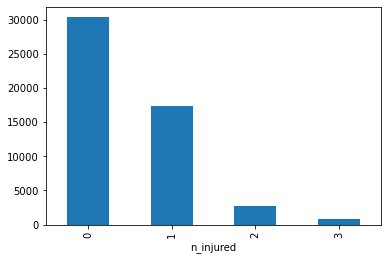

In [14]:

# In %
print((df_incident_no_outliers.groupby('n_injured').size()/len(df_incident_no_outliers)*100))

df_incident_no_outliers['n_injured'].value_counts().plot(kind='bar')

# Asimmetry index is pos
skewness_n_injured = df_incident_no_outliers['n_injured'].skew()
print('\n\n',"Skewness of n_injured: %f" % skewness_n_injured)

### Age and Sex distributions

<AxesSubplot:xlabel='n_females'>

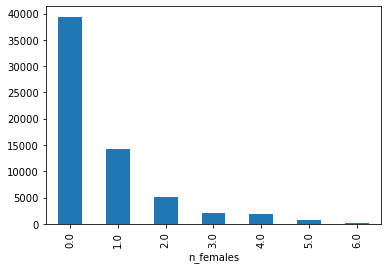

In [15]:
# Print the number of incident of with males and femals plots

# Males incidents
df_incident_no_outliers['n_males'].value_counts().plot(kind='bar')

# Females incidents
df_incident_no_outliers['n_females'].value_counts().plot(kind='bar')


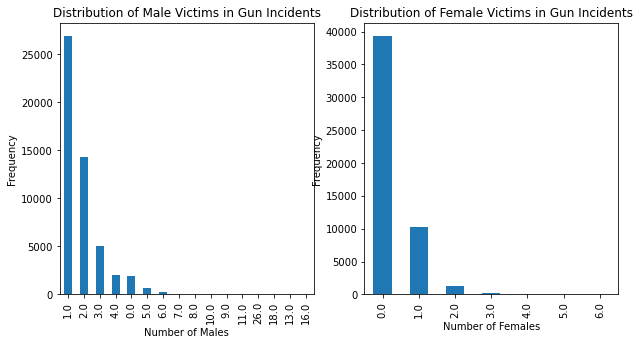

In [16]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

# Plot the male incidents in the first subplot
df_incident_no_outliers['n_males'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_xlabel('Number of Males')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Male Victims in Gun Incidents')

# Plot the female incidents in the second subplot
df_incident_no_outliers['n_females'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_xlabel('Number of Females')
# Numer of incidents with particular numb of female and male
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Female Victims in Gun Incidents')

# Display the plot
plt.show()

## Distribution of death in each state 


,geometry
0,"MULTIPOLYGON Z (((-118.59397 33.46720 0.00000,..."
1,"POLYGON Z ((-77.11976 38.93434 0.00000, -77.04..."
2,"MULTIPOLYGON Z (((-81.81169 24.56874 0.00000, ..."
3,"POLYGON Z ((-85.60516 34.98468 0.00000, -85.47..."
4,"POLYGON Z ((-117.24303 44.39097 0.00000, -117...."


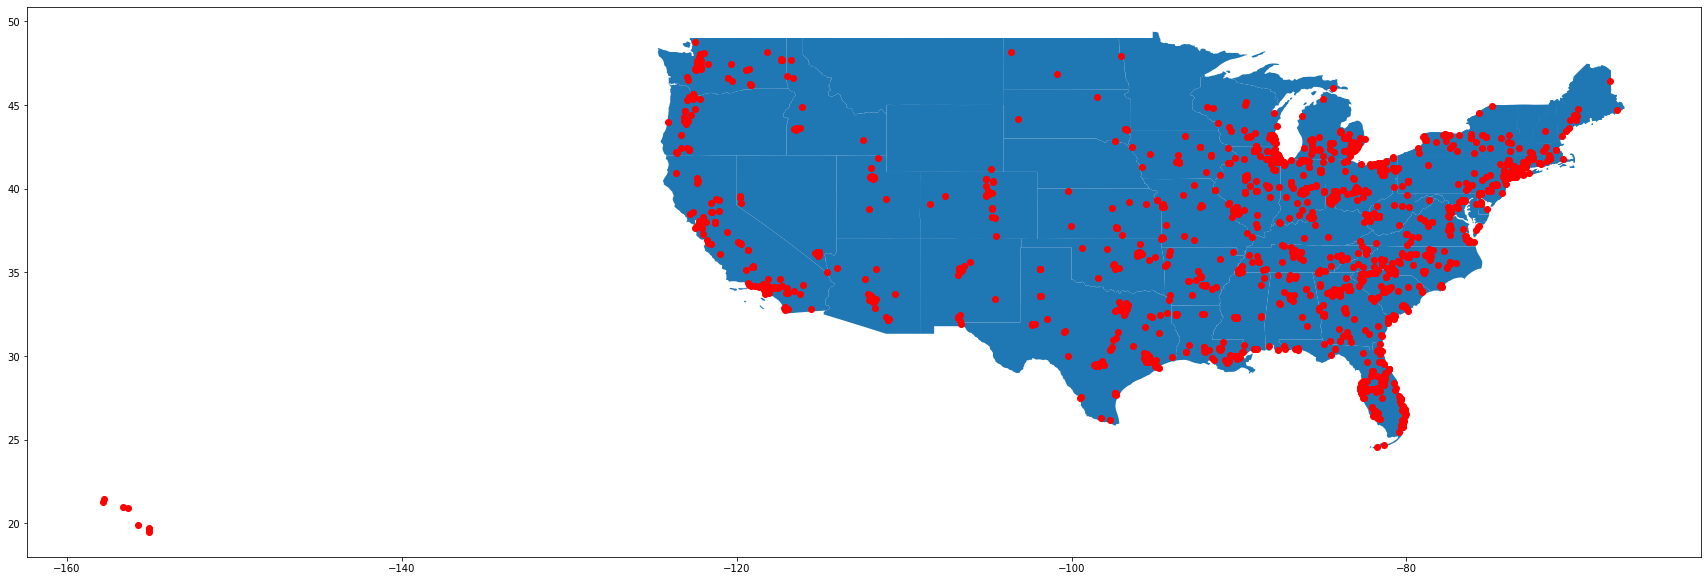

In [28]:
import geopandas as gpd
import matplotlib.pyplot as plt

usa_map = gpd.read_file('../map_data/usa-states-census-2014.shp')
# show map


usa_map.plot(figsize=(30,40))

# Draw red point for each latitude and longitude on df_incidents for 50 sampled incidents

sample_incidents = df_incidents_nodup.sample(2000)

for index, row in sample_incidents.iterrows():
    plt.plot(row['longitude'], row['latitude'], 'ro')
    

usa_map.head()


In [41]:
df_incidents_nodup['state'].unique()

# We have 49 states in the data but there are 50 american states why?


array(['Louisiana', 'Virginia', 'Oklahoma', 'Missouri', 'Illinois',
       'Michigan', 'Georgia', 'New York', 'Connecticut', 'Maine',
       'Maryland', 'Nevada', 'North Carolina', 'Iowa', 'South Carolina',
       'Arizona', 'Florida', 'New Jersey', 'West Virginia', 'Ohio',
       'Tennessee', 'California', 'Colorado', 'Kentucky', 'Wisconsin',
       'Utah', 'Alabama', 'Mississippi', 'New Mexico', 'Hawaii',
       'Pennsylvania', 'Texas', 'Delaware', 'Rhode Island',
       'Massachusetts', 'Washington', 'Arkansas', 'Indiana', 'Oregon',
       'Kansas', 'Alaska', 'South Dakota', 'Idaho', 'New Hampshire',
       'North Dakota', 'Wyoming', 'Montana', 'District of Columbia',
       'Minnesota'], dtype=object)

{'Georgia': 80, 'South Dakota': 6, 'Virginia': 50, 'Connecticut': 43, 'Ohio': 132, 'Oklahoma': 23, 'Delaware': 13, 'California': 96, 'Illinois': 273, 'Tennessee': 70, 'Indiana': 77, 'Arizona': 24, 'New York': 129, 'Florida': 151, 'Michigan': 77, 'South Carolina': 46, 'Wisconsin': 43, 'Hawaii': 8, 'Texas': 106, 'Missouri': 42, 'Alabama': 25, 'Louisiana': 64, 'Utah': 13, 'West Virginia': 23, 'North Carolina': 62, 'Kentucky': 6, 'Oregon': 28, 'Massachusetts': 11, 'New Jersey': 27, 'Colorado': 21, 'Washington': 46, 'Pennsylvania': 18, 'Arkansas': 24, 'Maryland': 11, 'Wyoming': 1, 'Iowa': 28, 'Rhode Island': 16, 'Kansas': 13, 'Mississippi': 15, 'New Mexico': 15, 'New Hampshire': 1, 'Nevada': 20, 'Maine': 11, 'Idaho': 9, 'North Dakota': 3}
45


<AxesSubplot:ylabel='Frequency'>

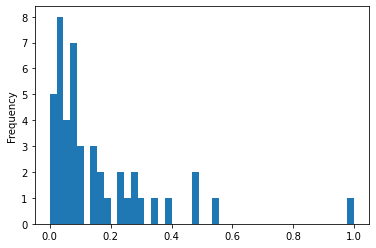

In [43]:
# Trying to plot a colormap or heatmap 

state_incidents = {}

usa_incidents_map = gpd.read_file('../map_data/usa-states-census-2014.shp')

# Counting the number of incidents per state
for state in sample_incidents['state'].unique():
    state_incidents[state] = len(sample_incidents[sample_incidents['state'] == state])


max_incidents = max(state_incidents.values())
min_incidents = min(state_incidents.values())

for state in state_incidents:
    state_incidents[state] = (state_incidents[state] - min_incidents) / (max_incidents - min_incidents)
    
# Convert in dataframe and divide key and value in two columns state and score
state_incidents_df = pd.DataFrame.from_dict(state_incidents, orient='index')
state_incidents_df.reset_index(inplace=True)
state_incidents_df.columns = ['state', 'score']


# histogram of the scores
# why 46? explore this
print(len(state_incidents_df['state'].unique()))
state_incidents_df['score'].plot(kind='hist', bins=len(state_incidents_df['state'].unique()))


# To get a color map we need to merge the map geometric data dataframe with state column (need to find or build it) with our dataset
